In [1]:
library(ggplot2)
library(data.table)
library(dplyr)
library(tidyr)
library(purrr) 
library(patchwork)
library(cowplot)
library(ggbreak)
library(scales)
if (!require(extrafont)) install.packages("extrafont")
library(extrafont)

# 3. 폰트 로드
loadfonts()

Warning message:
“패키지 ‘ggplot2’는 R 버전 4.3.3에서 작성되었습니다”
Warning message:
“패키지 ‘dplyr’는 R 버전 4.3.3에서 작성되었습니다”

다음의 패키지를 부착합니다: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Warning message:
“패키지 ‘tidyr’는 R 버전 4.3.3에서 작성되었습니다”
Warning message:
“패키지 ‘purrr’는 R 버전 4.3.3에서 작성되었습니다”

다음의 패키지를 부착합니다: ‘purrr’


The following object is masked from ‘package:data.table’:

    transpose


Warning message:
“패키지 ‘patchwork’는 R 버전 4.3.3에서 작성되었습니다”

다음의 패키지를 부착합니다: ‘cowplot’


The following object is masked from ‘package:patchwork’:

    align_plots


ggbreak v0.1.2

If you use ggbreak in published research, please cite the following
paper:

S Xu, M Chen, T Feng, L Zhan, L Zhou, G Yu. Use ggbreak to effectively
utilize plotting space to deal with large datasets and outliers.
Frontier

In [2]:
cohort <- "simulation" # UKB, GS

# Step 1. Load data

In [3]:
prediction_path <- paste0(
    "/data/jerrylee/pjt/BIGFAM.v.2.0/data/", 
    cohort, 
    "/scenarios/SC1-SC4.fixed.GSW.tsv"
)

df_prediction <- fread(
    prediction_path,
    sep = "\t"
)

head(df_prediction)

scenario,G,S,w,slope_slope,slope_slope_lower,slope_slope_upper,slope_intercept,slope_intercept_lower,slope_intercept_upper,slope_sig,pred_G,pred_G_lower,pred_G_upper,pred_S,pred_S_lower,pred_S_upper,pred_w,pred_w_lower,pred_w_upper
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
SC1,0.5,0.1,1.3,0.7561424,0.7009104,0.8241895,-0.7762546,-0.8508345,-0.6800193,slow,0.4997307,0.0000010,0.59803138,0.100027207,0.05279191,0.35355945,1.298701,1.724138,1.052632
SC2,0.5,0.1,1.3,1.2377609,1.1325671,1.3503776,-0.3510885,-0.5281518,-0.2023353,fast,0.4979194,0.4880778,0.49933276,0.101247286,0.10054808,0.10490034,100.000000,100.000000,16.666667
SC3,0.5,0.1,1.3,0.7878265,0.7435635,0.8373077,-0.6930705,-0.7609551,-0.6032038,slow,0.6300295,0.6023121,0.63129969,0.047568481,0.04712416,0.06050023,1.052632,1.143184,1.052632
SC4,0.5,0.1,1.3,0.7647846,0.7084024,0.8311256,-0.4914831,-0.5764579,-0.3892906,slow,0.0000010,0.0000010,0.02207389,0.418665525,0.40192866,0.42627698,1.694915,1.724138,1.666667
SC1,0.5,0.1,2.0,0.9990757,0.9212513,1.0913834,-0.5154353,-0.6311239,-0.3988698,similar,0.6889750,0.5995490,0.69757203,0.003907094,0.00000100,0.04975858,2.040816,2.500000,1.679966
SC2,0.5,0.1,2.0,1.2444795,1.1438122,1.3544987,-0.3483674,-0.4869465,-0.2158492,fast,0.4960101,0.4849277,0.49736817,0.101539588,0.10075677,0.10542744,100.000000,100.000000,15.325670


In [4]:
# annotate true decay pattern
df_prediction <- df_prediction %>%
    mutate(
        sig = case_when(
            w == 1.3 ~ "slow",
            w == 2.0 ~ "similar",
            w == 4.0 ~ "fast",
            TRUE ~ NA_character_  # 다른 값이 있을 경우 NA
        )
    )

dim(df_prediction)
# annotate true significant


[1] 12000    21

# plot theme

In [5]:
# 공통 테마 함수 정의
get_nature_theme <- function() {
    theme_bw() +
        theme(
            # 전체적인 배경
            panel.background = element_rect(fill = NA, color = NA),
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            panel.border = element_blank(),  
            
            # 축 설정
            axis.line.x.top = element_blank(),
            axis.line.y.right = element_blank(),
            axis.line.x.bottom = element_line(color = "black", size = 0.3),  
            axis.line.y.left = element_line(color = "black", size = 0.3),    
            axis.text = element_text(size = 6.5, color = "black"),
            axis.title = element_text(size = 7.5, color = "black"),
            axis.ticks = element_line(size = 0.3),
            axis.ticks.length = unit(0.8, "mm"),
            
            # 범례 설정
            legend.margin = margin(1, 1, 1, 1, unit = "mm"),
            # legend.spacing.y = unit(0.1, "cm"),
            
            # 여백 설정
            # plot.margin = unit(c(0.1, 0.2, 0.1, 0.1), "cm")
            plot.margin = margin(0, 0, 0, 0)
        )
}

# 공통 색상 정의
color_values <- c(
    "fast" = "#E64B35",
    "slow" = "#4DBBD5",
    "similar" = "#7E7E7E"
)

# Step 2. Plot

In [6]:
for_plot <- df_prediction %>% 
    filter(pred_G_lower > 1e-5 & pred_S_lower > 1e-5)

# for_plot <- df_prediction

# 필터링 결과 확인
dim(for_plot)

[1] 6056   21

## fast decaying

In [9]:
w_value <- 5

filtered_data <- for_plot %>%
    filter(w == w_value)

summary_data <- filtered_data %>%
    group_by(scenario) %>%
    summarise(
        mean_G = mean(pred_G),
        sd_G = sd(pred_G),
        mean_S = mean(pred_S),
        sd_S = sd(pred_S),
        mean_w = mean(pred_w),
        sd_w = sd(pred_w),
        .groups = 'drop'
    )

In [12]:
tt <- filtered_data %>%
    group_by(scenario) %>%
    summarise(
        mean_G = round(mean(pred_G), 3),
        sd_G = round(sd(pred_G), 3),
        mean_S = round(mean(pred_S), 3),
        sd_S = round(sd(pred_S), 3),
        mean_w = round(mean(pred_w), 3),
        sd_w = round(sd(pred_w), 3),
        .groups = 'drop'
    )
tt

scenario,mean_G,sd_G,mean_S,sd_S,mean_w,sd_w
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
SC1,0.496,0.013,0.102,0.006,4.936,0.519
SC2,0.496,0.003,0.102,0.002,92.097,18.997
SC3,0.506,0.010,0.111,0.005,6.155,0.638


Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`).”


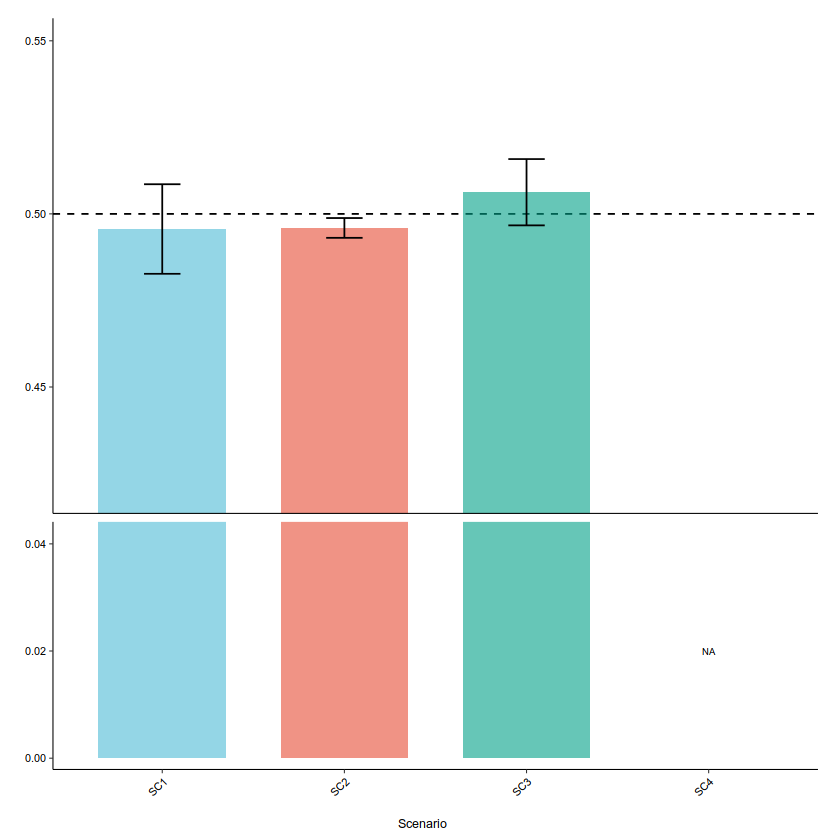

In [176]:
# G.variance
all_scenarios <- data.frame(scenario = c("SC1", "SC2", "SC3", "SC4"))

# 기존 summary_data와 합치기
plot_data <- all_scenarios %>%
    left_join(summary_data, by = "scenario")

plot <- ggplot(plot_data, aes(x = scenario, y = mean_G, fill = scenario)) +
    # reference line (true value)
    geom_hline(yintercept = 0.5, linetype = "dashed", color = "black") +  
    # violin plot
    geom_bar(stat = "identity", alpha = 0.6, width = 0.7) +
    geom_errorbar(aes(ymin = mean_G - sd_G, ymax = mean_G + sd_G), 
                 width = 0.2) +
    scale_fill_manual(values = scenario_colors) +
    # scale_x_discrete(
    #     labels = c(
    #         "SC1" = "reference",
    #         "SC2" = "family",
    #         "SC3" = "maternal",
    #         "SC4" = "2D-dominant"
    #     )
    # ) +
    scale_y_break(
        c(0.042, 0.42), 
        scales = 2) +
    scale_y_continuous(
        limits = c(0, 0.55),
        breaks = c(0, 0.02, 0.04, 0.45, 0.5, 0.55)) +
    # NA 표시를 위한 텍스트 추가
    geom_text(data = plot_data %>% filter(is.na(mean_G)),
              aes(y = 0.02, label = "NA"),  # y 위치를 0.45로 조정
              size = 2) +
    labs(x = "Scenario", title = "G.variance") +
    common_theme + 
    theme(
        plot.margin = margin(0, 0, 0, 0),
        axis.text.y.right = element_blank(),
        axis.ticks.y.right = element_blank()
    )

print(plot)

output_path <- paste0(
    "/data/jerrylee/pjt/BIGFAM.v.2.0/figures/", 
    cohort,
    ".scenarios.g", 
    gsub("\\.", "", as.character(w_value)),  # w값을 파일명에 포함
    ".prediction.pdf"
)

ggsave(
    filename = output_path,
    plot = plot,
    width = 40,
    height = 48,
    units = "mm",
    dpi = 300,
    device = cairo_pdf
)


Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`).”


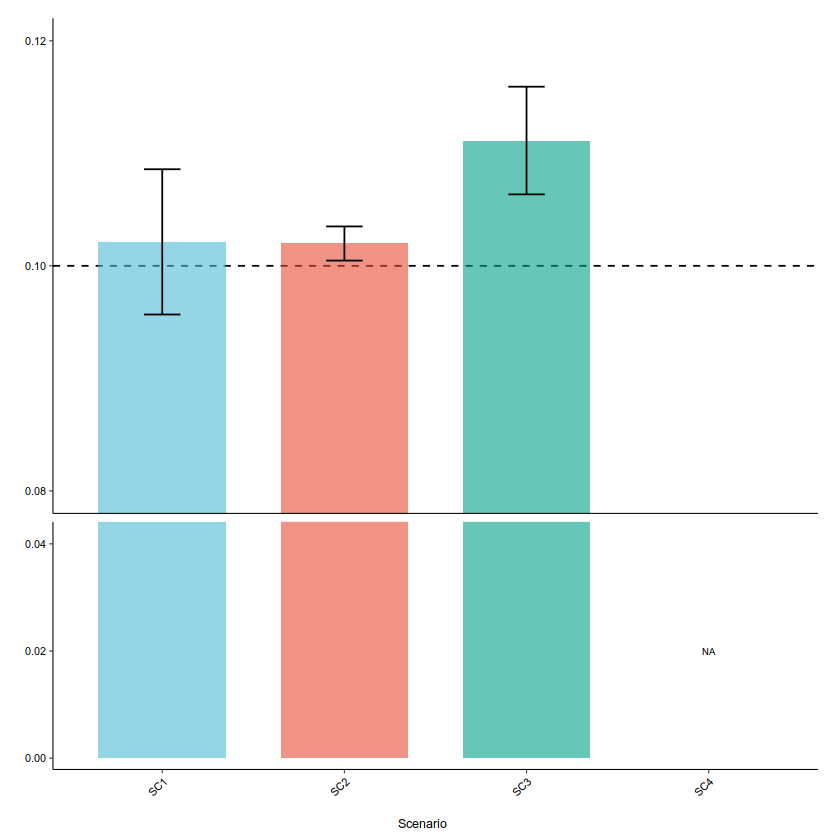

In [177]:
# S.variance
all_scenarios <- data.frame(scenario = c("SC1", "SC2", "SC3", "SC4"))

# 기존 summary_data와 합치기
plot_data <- all_scenarios %>%
    left_join(summary_data, by = "scenario")

plot <- ggplot(plot_data, aes(x = scenario, y = mean_S, fill = scenario)) +
    # reference line (true value)
    geom_hline(yintercept = 0.1, linetype = "dashed", color = "black") +  
    # violin plot
    geom_bar(stat = "identity", alpha = 0.6, width = 0.7) +
    geom_errorbar(aes(ymin = mean_S - sd_S, ymax = mean_S + sd_S), 
                 width = 0.2) +
    scale_fill_manual(values = scenario_colors) +
    scale_y_break(
        c(0.042, 0.08), 
        scales = 2) +
    scale_y_continuous(
        limits = c(0, 0.12),
        breaks = c(0, 0.02, 0.04, 0.08, 0.10, 0.12)) +
    # NA 표시를 위한 텍스트 추가
    geom_text(data = plot_data %>% filter(is.na(mean_S)),
              aes(y = 0.02, label = "NA"),  # y 위치를 0.45로 조정
              size = 2) +
    labs(x = "Scenario", title = "S.variance") +
    common_theme + 
    theme(
        plot.margin = margin(0, 0, 0, 0),
        axis.text.y.right = element_blank(),
        axis.ticks.y.right = element_blank()
    )

print(plot)

output_path <- paste0(
    "/data/jerrylee/pjt/BIGFAM.v.2.0/figures/", 
    cohort,
    ".scenarios.s", 
    gsub("\\.", "", as.character(w_value)),  # w값을 파일명에 포함
    ".prediction.pdf"
)

ggsave(
    filename = output_path,
    plot = plot,
    width = 40,
    height = 48,
    units = "mm",
    dpi = 300,
    device = cairo_pdf
)


Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`).”


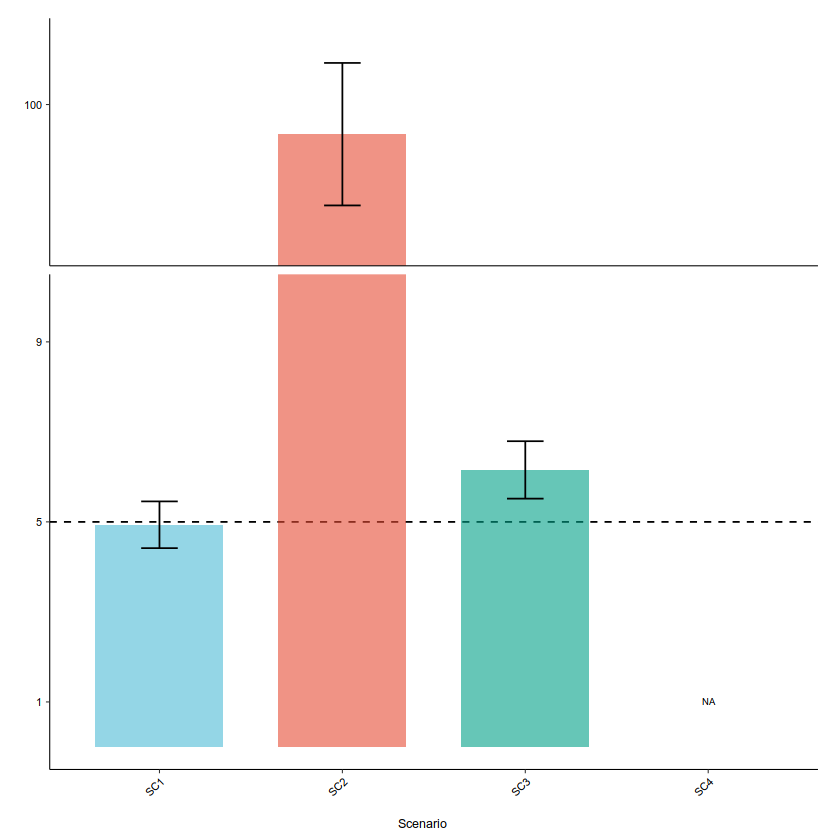

In [178]:
# S.variance
all_scenarios <- data.frame(scenario = c("SC1", "SC2", "SC3", "SC4"))

# 기존 summary_data와 합치기
plot_data <- all_scenarios %>%
    left_join(summary_data, by = "scenario")

plot <- ggplot(plot_data, aes(x = scenario, y = mean_w, fill = scenario)) +
    # reference line (true value)
    geom_hline(yintercept = w_value, linetype = "dashed", color = "black") +  
    # violin plot
    geom_bar(stat = "identity", alpha = 0.6, width = 0.7) +
    geom_errorbar(aes(ymin = mean_w - sd_w, ymax = mean_w + sd_w), 
                 width = 0.2) +
    scale_fill_manual(values = scenario_colors) +
    scale_y_break(c(10, 60), scales = 0.5) +
    scale_y_continuous(limits = c(0, 120),
        breaks = c(1, 5, 9, 100)) +
    # NA 표시를 위한 텍스트 추가
    geom_text(data = plot_data %>% filter(is.na(mean_w)),
              aes(y = 1, label = "NA"),  # y 위치를 0.45로 조정
              size = 2) +
    labs(x = "Scenario", title = "S.variance") +
    common_theme + 
    theme(
        plot.margin = margin(0, 0, 0, 0),
        axis.text.y.right = element_blank(),
        axis.ticks.y.right = element_blank()
    )

print(plot)

output_path <- paste0(
    "/data/jerrylee/pjt/BIGFAM.v.2.0/figures/", 
    cohort,
    ".scenarios.w", 
    gsub("\\.", "", as.character(w_value)),  # w값을 파일명에 포함
    ".prediction.pdf"
)

ggsave(
    filename = output_path,
    plot = plot,
    width = 40,
    height = 48,
    units = "mm",
    dpi = 300,
    device = cairo_pdf
)


## similar decaying

In [179]:
w_value <- 2

filtered_data <- for_plot %>%
    filter(w == w_value)

summary_data <- filtered_data %>%
    group_by(scenario) %>%
    summarise(
        mean_G = mean(pred_G),
        sd_G = sd(pred_G),
        mean_S = mean(pred_S),
        sd_S = sd(pred_S),
        mean_w = mean(pred_w),
        sd_w = sd(pred_w),
        .groups = 'drop'
    )

summary_data

scenario,mean_G,sd_G,mean_S,sd_S,mean_w,sd_w
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
SC1,0.6634141,0.0265867844,0.01821071,0.0137639211,2.055250,0.08157173
SC2,0.4960485,0.0027655759,0.10194896,0.0014818888,93.448571,17.34706413
SC3,0.5452977,0.0635223145,0.08798662,0.0307934378,2.209719,0.12826040
SC4,0.5252213,0.0002775168,0.14520151,0.0007070159,2.036428,0.01183661


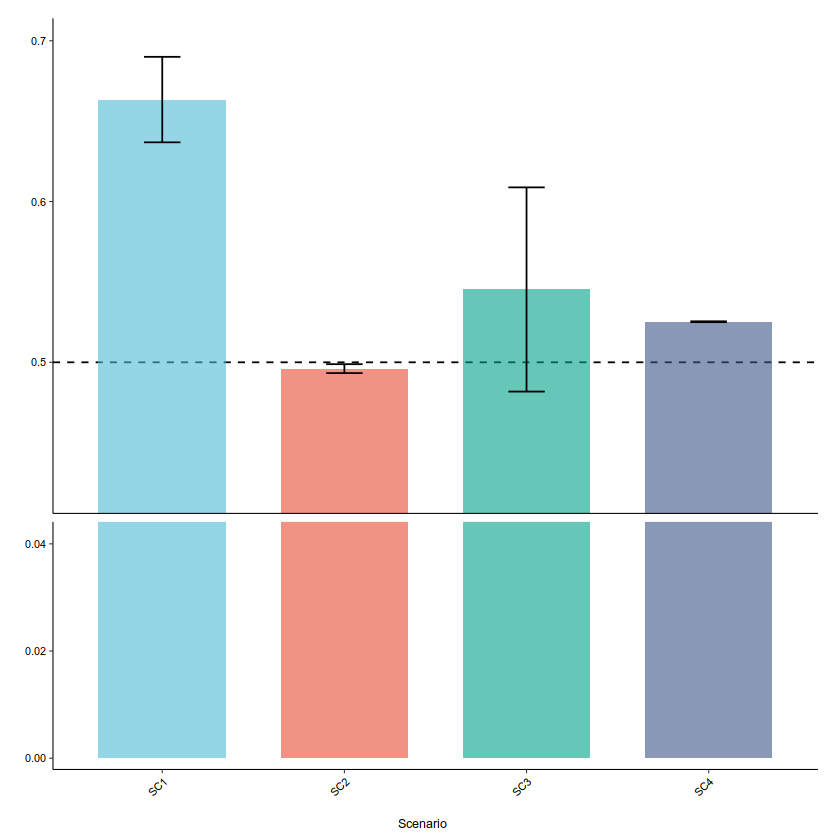

In [180]:
# G.variance
all_scenarios <- data.frame(scenario = c("SC1", "SC2", "SC3", "SC4"))

# 기존 summary_data와 합치기
plot_data <- all_scenarios %>%
    left_join(summary_data, by = "scenario")

plot <- ggplot(plot_data, aes(x = scenario, y = mean_G, fill = scenario)) +
    # reference line (true value)
    geom_hline(yintercept = 0.5, linetype = "dashed", color = "black") +  
    # violin plot
    geom_bar(stat = "identity", alpha = 0.6, width = 0.7) +
    geom_errorbar(aes(ymin = mean_G - sd_G, ymax = mean_G + sd_G), 
                 width = 0.2) +
    scale_fill_manual(values = scenario_colors) +
    scale_y_break(
        c(0.042, 0.42), 
        scales = 2) +
    scale_y_continuous(
        limits = c(0, 0.7),
        breaks = c(0, 0.02, 0.04, 0.4, 0.5, 0.6, 0.7)) +
    # NA 표시를 위한 텍스트 추가
    geom_text(data = plot_data %>% filter(is.na(mean_G)),
              aes(y = 0.02, label = "NA"),  # y 위치를 0.45로 조정
              size = 2) +
    labs(x = "Scenario", title = "G.variance") +
    common_theme + 
    theme(
        plot.margin = margin(0, 0, 0, 0),
        axis.text.y.right = element_blank(),
        axis.ticks.y.right = element_blank()
    )

print(plot)

output_path <- paste0(
    "/data/jerrylee/pjt/BIGFAM.v.2.0/figures/", 
    cohort,
    ".scenarios.g", 
    gsub("\\.", "", as.character(w_value)),  # w값을 파일명에 포함
    ".prediction.pdf"
)

ggsave(
    filename = output_path,
    plot = plot,
    width = 40,
    height = 48,
    units = "mm",
    dpi = 300,
    device = cairo_pdf
)


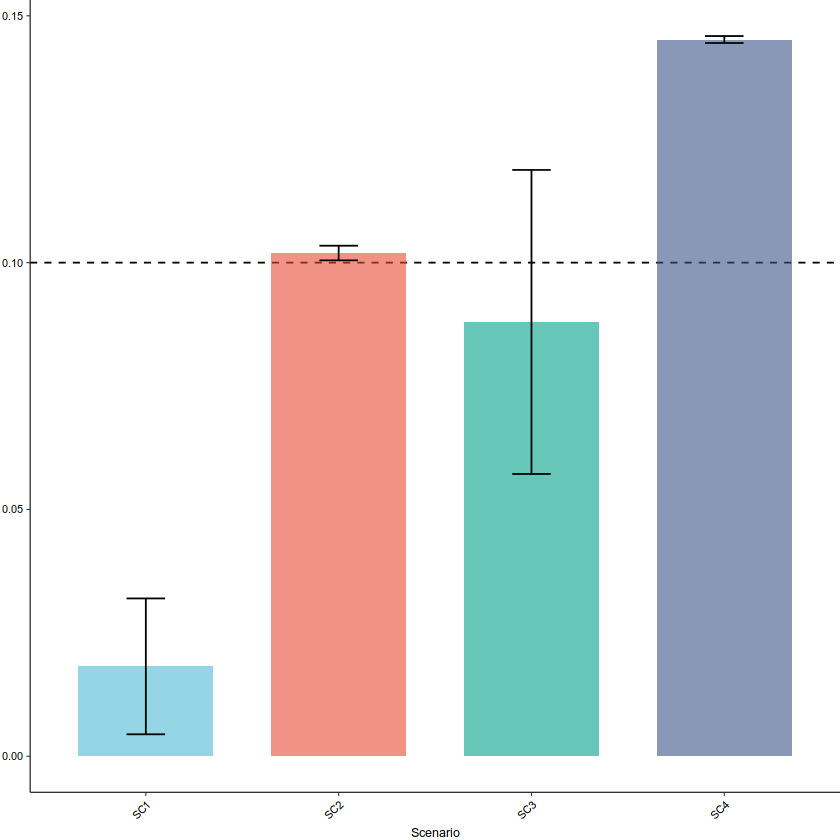

In [181]:
# S.variance
all_scenarios <- data.frame(scenario = c("SC1", "SC2", "SC3", "SC4"))

# 기존 summary_data와 합치기
plot_data <- all_scenarios %>%
    left_join(summary_data, by = "scenario")

plot <- ggplot(plot_data, aes(x = scenario, y = mean_S, fill = scenario)) +
    # reference line (true value)
    geom_hline(yintercept = 0.1, linetype = "dashed", color = "black") +  
    # violin plot
    geom_bar(stat = "identity", alpha = 0.6, width = 0.7) +
    geom_errorbar(aes(ymin = mean_S - sd_S, ymax = mean_S + sd_S), 
                 width = 0.2) +
    scale_fill_manual(values = scenario_colors) +
    # scale_y_break(
    #     c(0.042, 0.08), 
    #     scales = 2) +
    # scale_y_continuous(
    #     limits = c(0, 0.12),
    #     breaks = c(0, 0.02, 0.04, 0.08, 0.10, 0.12)) +
    # NA 표시를 위한 텍스트 추가
    geom_text(data = plot_data %>% filter(is.na(mean_S)),
              aes(y = 0.02, label = "NA"),  # y 위치를 0.45로 조정
              size = 2) +
    labs(x = "Scenario", title = "S.variance") +
    common_theme + 
    theme(
        plot.margin = margin(0, 0, 0, 0),
        axis.text.y.right = element_blank(),
        axis.ticks.y.right = element_blank()
    )

print(plot)

output_path <- paste0(
    "/data/jerrylee/pjt/BIGFAM.v.2.0/figures/", 
    cohort,
    ".scenarios.s", 
    gsub("\\.", "", as.character(w_value)),  # w값을 파일명에 포함
    ".prediction.pdf"
)

ggsave(
    filename = output_path,
    plot = plot,
    width = 40,
    height = 48,
    units = "mm",
    dpi = 300,
    device = cairo_pdf
)


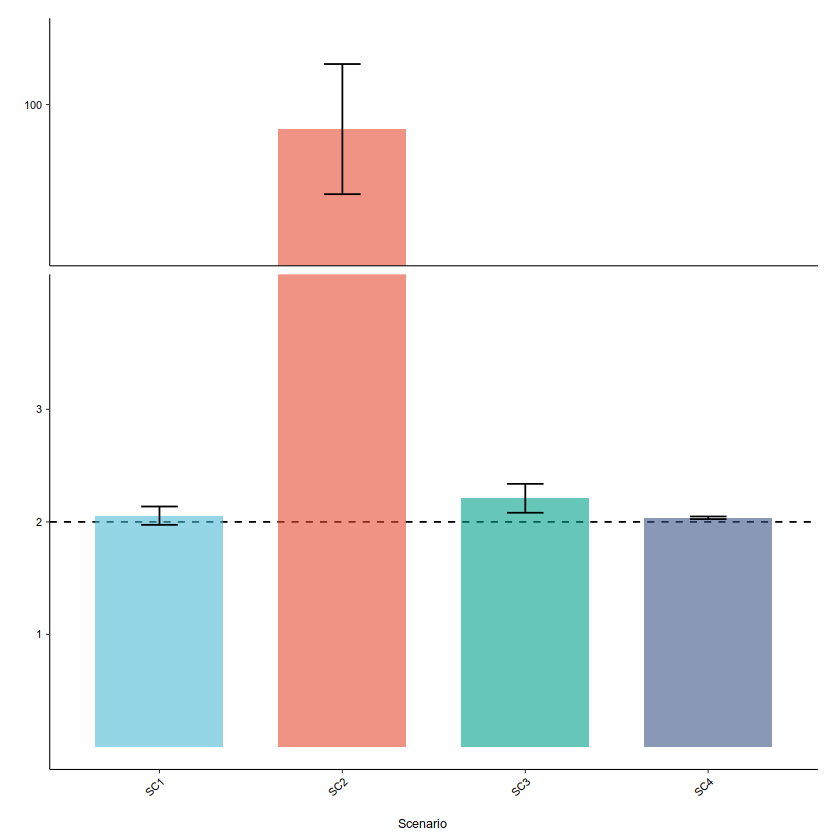

In [182]:
# S.variance
all_scenarios <- data.frame(scenario = c("SC1", "SC2", "SC3", "SC4"))

# 기존 summary_data와 합치기
plot_data <- all_scenarios %>%
    left_join(summary_data, by = "scenario")

plot <- ggplot(plot_data, aes(x = scenario, y = mean_w, fill = scenario)) +
    # reference line (true value)
    geom_hline(yintercept = w_value, linetype = "dashed", color = "black") +  
    # violin plot
    geom_bar(stat = "identity", alpha = 0.6, width = 0.7) +
    geom_errorbar(aes(ymin = mean_w - sd_w, ymax = mean_w + sd_w), 
                 width = 0.2) +
    scale_fill_manual(values = scenario_colors) +
    scale_y_break(c(4, 60), scales = 0.5) +
    scale_y_continuous(limits = c(0, 120),
        breaks = c(1, 2, 3, 100)) +
    # NA 표시를 위한 텍스트 추가
    geom_text(data = plot_data %>% filter(is.na(mean_w)),
              aes(y = 1, label = "NA"),  # y 위치를 0.45로 조정
              size = 2) +
    labs(x = "Scenario", title = "S.variance") +
    common_theme + 
    theme(
        plot.margin = margin(0, 0, 0, 0),
        axis.text.y.right = element_blank(),
        axis.ticks.y.right = element_blank()
    )

print(plot)

output_path <- paste0(
    "/data/jerrylee/pjt/BIGFAM.v.2.0/figures/", 
    cohort,
    ".scenarios.w", 
    gsub("\\.", "", as.character(w_value)),  # w값을 파일명에 포함
    ".prediction.pdf"
)

ggsave(
    filename = output_path,
    plot = plot,
    width = 40,
    height = 48,
    units = "mm",
    dpi = 300,
    device = cairo_pdf
)


# slow decaying

In [183]:
w_value <- 1.3

filtered_data <- for_plot %>%
    filter(w == w_value)

summary_data <- filtered_data %>%
    group_by(scenario) %>%
    summarise(
        mean_G = mean(pred_G),
        sd_G = sd(pred_G),
        mean_S = mean(pred_S),
        sd_S = sd(pred_S),
        mean_w = mean(pred_w),
        sd_w = sd(pred_w),
        .groups = 'drop'
    )

summary_data

scenario,mean_G,sd_G,mean_S,sd_S,mean_w,sd_w
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
SC1,0.5190488,0.019197038,0.09050111,0.0093442652,1.258491,0.042176771
SC2,0.4961610,0.002718188,0.10185275,0.0014831631,93.295238,17.399900020
SC3,0.6329519,0.002407993,0.04685287,0.0008095254,1.052868,0.002461075


Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`).”


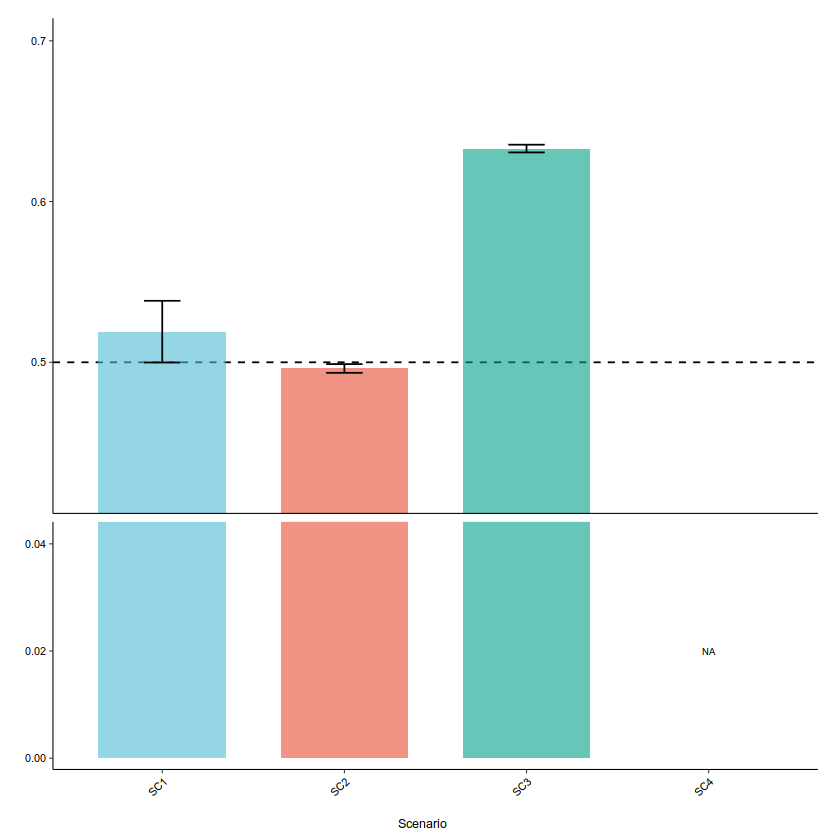

In [184]:
# G.variance
all_scenarios <- data.frame(scenario = c("SC1", "SC2", "SC3", "SC4"))

# 기존 summary_data와 합치기
plot_data <- all_scenarios %>%
    left_join(summary_data, by = "scenario")

plot <- ggplot(plot_data, aes(x = scenario, y = mean_G, fill = scenario)) +
    # reference line (true value)
    geom_hline(yintercept = 0.5, linetype = "dashed", color = "black") +  
    # violin plot
    geom_bar(stat = "identity", alpha = 0.6, width = 0.7) +
    geom_errorbar(aes(ymin = mean_G - sd_G, ymax = mean_G + sd_G), 
                 width = 0.2) +
    scale_fill_manual(values = scenario_colors) +
    scale_y_break(
        c(0.042, 0.42), 
        scales = 2) +
    scale_y_continuous(
        limits = c(0, 0.7),
        breaks = c(0, 0.02, 0.04, 0.4, 0.5, 0.6, 0.7)) +
    # NA 표시를 위한 텍스트 추가
    geom_text(data = plot_data %>% filter(is.na(mean_G)),
              aes(y = 0.02, label = "NA"),  # y 위치를 0.45로 조정
              size = 2) +
    labs(x = "Scenario", title = "G.variance") +
    common_theme + 
    theme(
        plot.margin = margin(0, 0, 0, 0),
        axis.text.y.right = element_blank(),
        axis.ticks.y.right = element_blank()
    )

print(plot)

output_path <- paste0(
    "/data/jerrylee/pjt/BIGFAM.v.2.0/figures/", 
    cohort,
    ".scenarios.g", 
    gsub("\\.", "", as.character(w_value)),  # w값을 파일명에 포함
    ".prediction.pdf"
)

ggsave(
    filename = output_path,
    plot = plot,
    width = 40,
    height = 48,
    units = "mm",
    dpi = 300,
    device = cairo_pdf
)


Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`).”


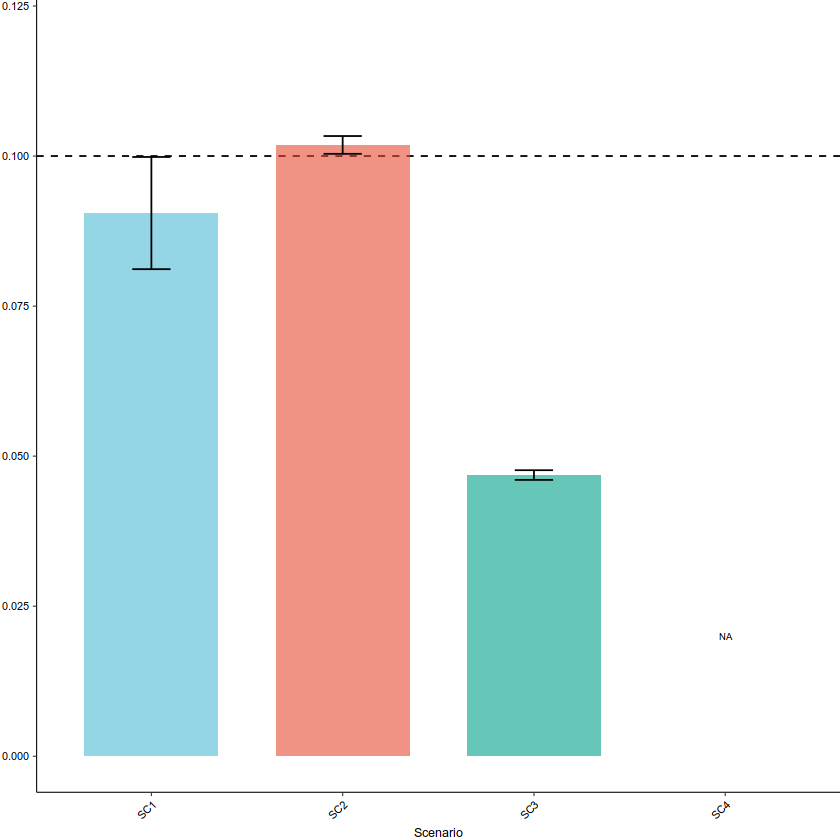

In [186]:
# S.variance
all_scenarios <- data.frame(scenario = c("SC1", "SC2", "SC3", "SC4"))

# 기존 summary_data와 합치기
plot_data <- all_scenarios %>%
    left_join(summary_data, by = "scenario")

plot <- ggplot(plot_data, aes(x = scenario, y = mean_S, fill = scenario)) +
    # reference line (true value)
    geom_hline(yintercept = 0.1, linetype = "dashed", color = "black") +  
    # violin plot
    geom_bar(stat = "identity", alpha = 0.6, width = 0.7) +
    geom_errorbar(aes(ymin = mean_S - sd_S, ymax = mean_S + sd_S), 
                 width = 0.2) +
    scale_fill_manual(values = scenario_colors) +
    # scale_y_break(
    #     c(0.042, 0.08), 
    #     scales = 2) +
    scale_y_continuous(
        limits = c(0, 0.12)) +
    # NA 표시를 위한 텍스트 추가
    geom_text(data = plot_data %>% filter(is.na(mean_S)),
              aes(y = 0.02, label = "NA"),  # y 위치를 0.45로 조정
              size = 2) +
    labs(x = "Scenario", title = "S.variance") +
    common_theme + 
    theme(
        plot.margin = margin(0, 0, 0, 0),
        axis.text.y.right = element_blank(),
        axis.ticks.y.right = element_blank()
    )

print(plot)

output_path <- paste0(
    "/data/jerrylee/pjt/BIGFAM.v.2.0/figures/", 
    cohort,
    ".scenarios.S", 
    gsub("\\.", "", as.character(w_value)),  # w값을 파일명에 포함
    ".prediction.pdf"
)

ggsave(
    filename = output_path,
    plot = plot,
    width = 40,
    height = 48,
    units = "mm",
    dpi = 300,
    device = cairo_pdf
)


Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`).”


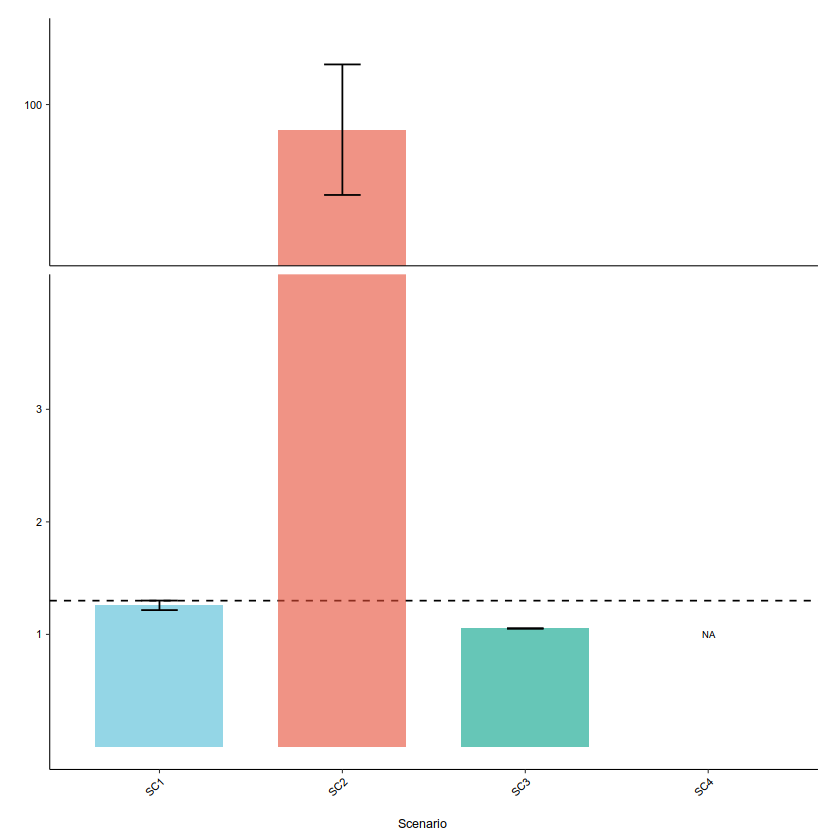

In [187]:
# S.variance
all_scenarios <- data.frame(scenario = c("SC1", "SC2", "SC3", "SC4"))

# 기존 summary_data와 합치기
plot_data <- all_scenarios %>%
    left_join(summary_data, by = "scenario")

plot <- ggplot(plot_data, aes(x = scenario, y = mean_w, fill = scenario)) +
    # reference line (true value)
    geom_hline(yintercept = w_value, linetype = "dashed", color = "black") +  
    # violin plot
    geom_bar(stat = "identity", alpha = 0.6, width = 0.7) +
    geom_errorbar(aes(ymin = mean_w - sd_w, ymax = mean_w + sd_w), 
                 width = 0.2) +
    scale_fill_manual(values = scenario_colors) +
    scale_y_break(c(4, 60), scales = 0.5) +
    scale_y_continuous(limits = c(0, 120),
        breaks = c(1, 2, 3, 100)) +
    # NA 표시를 위한 텍스트 추가
    geom_text(data = plot_data %>% filter(is.na(mean_w)),
              aes(y = 1, label = "NA"),  # y 위치를 0.45로 조정
              size = 2) +
    labs(x = "Scenario", title = "S.variance") +
    common_theme + 
    theme(
        plot.margin = margin(0, 0, 0, 0),
        axis.text.y.right = element_blank(),
        axis.ticks.y.right = element_blank()
    )

print(plot)

output_path <- paste0(
    "/data/jerrylee/pjt/BIGFAM.v.2.0/figures/", 
    cohort,
    ".scenarios.w", 
    gsub("\\.", "", as.character(w_value)),  # w값을 파일명에 포함
    ".prediction.pdf"
)

ggsave(
    filename = output_path,
    plot = plot,
    width = 40,
    height = 48,
    units = "mm",
    dpi = 300,
    device = cairo_pdf
)


Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`).”


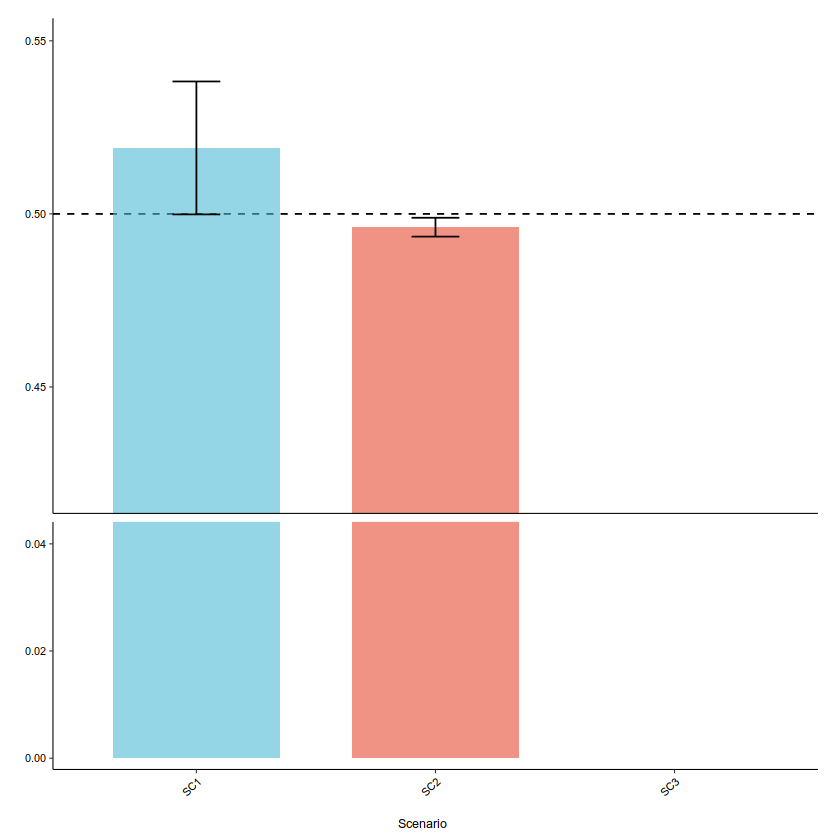

In [129]:
w_value <- 1.3

filtered_data <- for_plot %>%
    filter(w == w_value)

summary_data <- filtered_data %>%
    group_by(scenario) %>%
    summarise(
        mean_G = mean(pred_G),
        sd_G = sd(pred_G),
        mean_S = mean(pred_S),
        sd_S = sd(pred_S),
        mean_w = mean(pred_w),
        sd_w = sd(pred_w),
        .groups = 'drop'
    )


plot <- ggplot(summary_data, aes(x = scenario, y = mean_G, fill = scenario)) +
    # reference line (true value)
    geom_hline(yintercept = 0.5, linetype = "dashed", color = "black") +  
    # violin plot
    geom_bar(stat = "identity", alpha = 0.6, width = 0.7) +
    geom_errorbar(aes(ymin = mean_G - sd_G, ymax = mean_G + sd_G), 
                         width = 0.2) +
    scale_fill_manual(values = scenario_colors) +
    scale_y_break(
        c(0.042, 0.42), 
        scales = 2) +
    scale_y_continuous(
        limits = c(0, 0.55),
        breaks = c(0, 0.02, 0.04, 0.45, 0.5, 0.55)) +
    labs(x = "Scenario", title = "G.variance") +
    common_theme + 
    theme(
        plot.margin = margin(0, 0, 0, 0),
        axis.text.y.right = element_blank(),
        axis.ticks.y.right = element_blank()
    )
print(plot)

output_path <- paste0(
    "/data/jerrylee/pjt/BIGFAM.v.2.0/figures/", 
    "test.scenarios.g", 
    gsub("\\.", "", as.character(true_w)),  # w값을 파일명에 포함
    ".prediction.pdf"
)

ggsave(
    filename = output_path,
    plot = plot,
    width = 34.5,
    height = 38,
    units = "mm",
    dpi = 300,
    device = cairo_pdf
)


In [101]:
plot_scenario_predictions <- function(data, w_value, variable = "w", true_values) {
    # w값에 해당하는 데이터만 필터링
    filtered_data <- data %>%
        filter(w == w_value)
    
    # 평균과 표준편차 계산
    summary_data <- filtered_data %>%
        group_by(scenario) %>%
        summarise(
            mean_G = mean(pred_G),
            sd_G = sd(pred_G),
            mean_S = mean(pred_S),
            sd_S = sd(pred_S),
            mean_w = mean(pred_w),
            sd_w = sd(pred_w),
            .groups = 'drop'
        )
    
    # 시나리오별 색상 정의
    scenario_colors <- c(
        "SC1" = "#4DBBD5",
        "SC2" = "#E64B35",
        "SC3" = "#00A087",
        "SC4" = "#3C5488"
    )

    common_theme <- get_nature_theme() +
        theme(
            axis.text.x = element_text(angle = 45, hjust = 1),
            legend.position = "none",
            # plot.margin = margin(20, 5, 5, 5),  # 상단 여백 증가
            # plot.title = element_text(
            #     hjust = 0.5, 
            #     margin = margin(b = 10),
            #     size = 10  # 글자 크기 조절 (기본값은 보통 14)
            # ),
            plot.title = element_blank(),
            axis.title.y = element_blank()  # y축 라벨 제거
        )
    
    # 변수에 따른 플롯 생성
    if(variable == "G") {
        plot <- ggplot(summary_data, aes(x = scenario, y = mean_G, fill = scenario)) +
            geom_hline(yintercept = true_values["G"], linetype = "dashed", color = "black") +  # true 값 추가
            geom_bar(stat = "identity", alpha = 0.6, width = 0.7) +
            geom_errorbar(aes(ymin = mean_G - sd_G, ymax = mean_G + sd_G), 
                         width = 0.2) +
            scale_fill_manual(values = scenario_colors) +
            scale_y_break(
                c(0.042, 0.42), 
                scales = c(0.8, 0.2)) +
            scale_y_continuous(
                limits = c(0, 0.55),
                breaks = c(0, 0.02, 0.04, 0.45, 0.5, 0.55)) +
            labs(x = "Scenario", title = "G. variance") +
            common_theme + 
            theme(
                plot.margin = margin(0, 0, 0, 0),
                axis.text.y.right = element_blank(),
                axis.ticks.y.right = element_blank()
            )
    } else if(variable == "S") {
        plot <- ggplot(summary_data, aes(x = scenario, y = mean_S, fill = scenario)) +
            geom_hline(yintercept = true_values["S"], linetype = "dashed", color = "black") +  # true 값 추가
            geom_bar(stat = "identity", alpha = 0.6, width = 0.7) +
            geom_errorbar(aes(ymin = mean_S - sd_S, ymax = mean_S + sd_S), 
                         width = 0.2) +
            scale_fill_manual(values = scenario_colors) +
            labs(x = "Scenario", title = "S. variance") +
            common_theme
    } else if(variable == "w") {
        plot <- ggplot(summary_data, aes(x = scenario, y = mean_w, fill = scenario)) +
            geom_hline(yintercept = true_values["w"], linetype = "dashed", color = "black") +  # true 값 추가
            geom_bar(stat = "identity", alpha = 0.6, width = 0.7) +
            geom_errorbar(aes(ymin = mean_w - sd_w, ymax = mean_w + sd_w), 
                         width = 0.2) +
            scale_fill_manual(values = scenario_colors) +
            scale_y_break(c(7, 60), scales = c(0.2, 1)) +
            scale_y_continuous(breaks = c(0, 2, 4, 6, 100)) +
            labs(x = "Scenario", title = "S. decay") +
            common_theme + 
            theme(
                plot.margin = margin(0, 0, 0, 0),
                axis.text.y.right = element_blank(),
                axis.ticks.y.right = element_blank()
            )
    }

    return(plot)
}

In [87]:
true_w <- 5

true_values <- c(G = 0.5, S = 0.1, w = true_w)  # true 값 설정

p_g <- plot_scenario_predictions(df_prediction, true_w, "G", true_values)
p_s <- plot_scenario_predictions(df_prediction, true_w, "S", true_values)
p_w <- plot_scenario_predictions(df_prediction, true_w, "w", true_values)

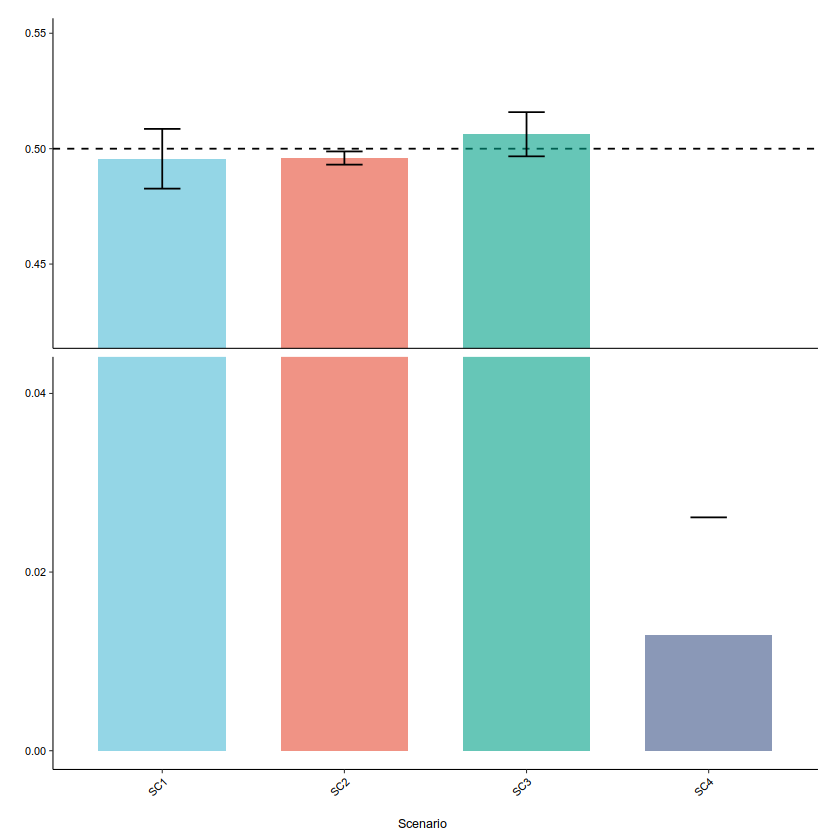

In [88]:
print(p_g)
# 파일 저장
output_path <- paste0(
    "/data/jerrylee/pjt/BIGFAM.v.2.0/figures/", 
    cohort, 
    ".scenarios.g", 
    gsub("\\.", "", as.character(true_w)),  # w값을 파일명에 포함
    ".prediction.pdf"
)

ggsave(
    filename = output_path,
    plot = p_g,
    width = 34.5,
    height = 38,
    units = "mm",
    dpi = 300,
    device = cairo_pdf
)


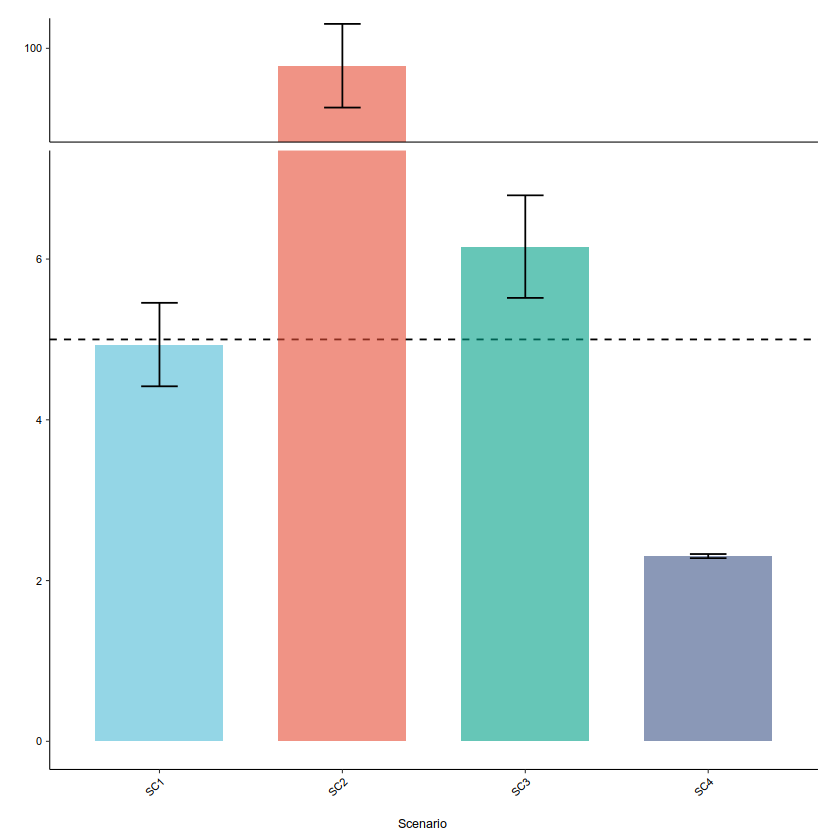

In [89]:
print(p_w)

# 파일 저장
output_path <- paste0(
    "/data/jerrylee/pjt/BIGFAM.v.2.0/figures/", 
    cohort, 
    ".scenarios.w", 
    gsub("\\.", "", as.character(true_w)),  # w값을 파일명에 포함
    ".prediction.pdf"
)

ggsave(
    filename = output_path,
    plot = p_w,
    width = 41,
    height = 44.45,
    units = "mm",
    dpi = 300,
    device = cairo_pdf
)


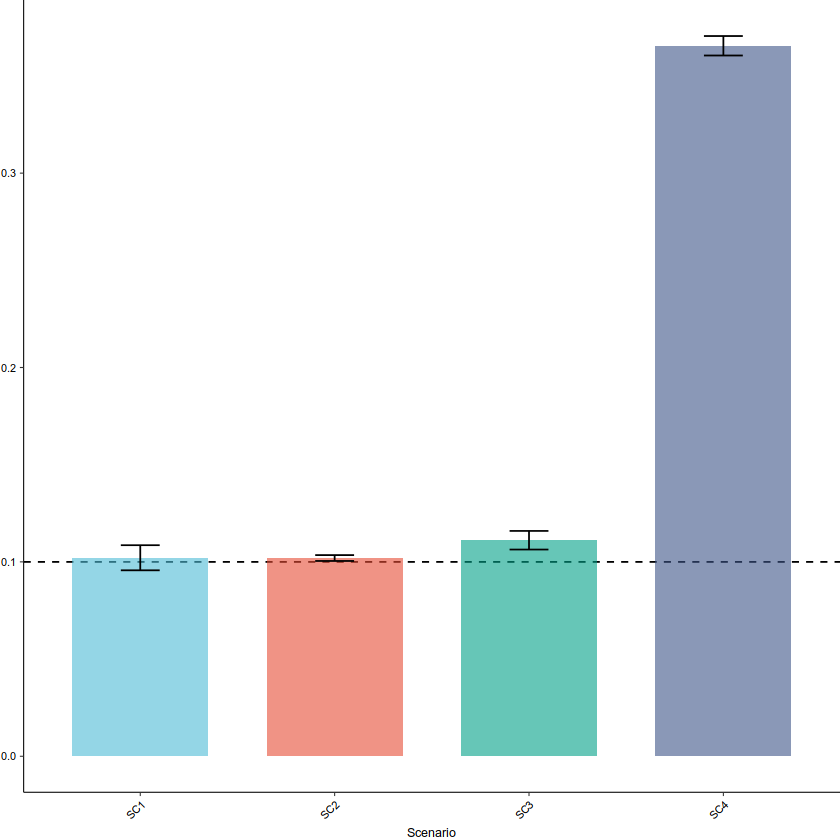

In [90]:
print(p_s)
# 파일 저장
output_path <- paste0(
    "/data/jerrylee/pjt/BIGFAM.v.2.0/figures/", 
    cohort, 
    ".scenarios.S", 
    gsub("\\.", "", as.character(true_w)),  # w값을 파일명에 포함
    ".prediction.pdf"
)

ggsave(
    filename = output_path,
    plot = p_s,
    width = 34.5,
    height = 38,
    units = "mm",
    dpi = 300,
    device = cairo_pdf
)


# facet


In [156]:
plot_scenario_predictions_facet <- function(data, w_values, true_values) {
    # 데이터 준비
    all_predictions <- lapply(w_values, function(w_val) {
        filtered_data <- data %>%
            filter(w == w_val) %>%
            group_by(scenario) %>%
            summarise(
                G_mean = mean(pred_G),
                G_sd = sd(pred_G),
                S_mean = mean(pred_S),
                S_sd = sd(pred_S),
                .groups = 'drop'
            ) %>%
            mutate(w_value = paste0("w: ", w_val))
    }) %>% bind_rows()
    
    # 데이터를 long 형태로 변환
    long_data <- all_predictions %>%
        pivot_longer(
            cols = c(G_mean, S_mean),
            names_to = "variable",
            values_to = "mean"
        ) %>%
        mutate(
            sd = case_when(
                variable == "G_mean" ~ G_sd,
                variable == "S_mean" ~ S_sd
            ),
            variable = factor(variable,
                            levels = c("G_mean", "S_mean"),
                            labels = c("G. variance", "S. variance"))
        )
    
    # 시나리오별 색상 정의
    scenario_colors <- c(
        "SC1" = "#4DBBD5",
        "SC2" = "#E64B35",
        "SC3" = "#00A087",
        "SC4" = "#3C5488"
    )
    
    # Plot 생성
    p <- ggplot(long_data, aes(x = scenario, y = mean, fill = scenario)) +
        geom_bar(stat = "identity", alpha = 0.6, width = 0.7) +
        geom_errorbar(aes(ymin = mean - sd, ymax = mean + sd), width = 0.2) +
        geom_hline(data = data.frame(
            variable = c("G. variance", "S. variance"),
            true_value = c(true_values["G"], true_values["S"])
        ), aes(yintercept = true_value), linetype = "dashed") +
        scale_fill_manual(values = scenario_colors) +
        facet_grid(variable ~ w_value, scales = "free_y") +
        labs(x = "Scenario", y = "") +
        theme_minimal() +
        theme(
            # 패널 배경과 테두리 설정
            panel.background = element_rect(fill = "white", color = "black"),  # 테두리 검은색
            panel.grid.major = element_line(color = "gray90"),
            panel.grid.minor = element_line(color = "gray95"),
            
            # facet strip 설정
            strip.background = element_rect(fill = "#FFFAE6", color = "black"),  # strip 테두리도 검은색
            strip.text = element_text(size = 10, color = "gray20"),
            strip.text.y = element_text(angle = 0),
            
            # 기타 설정
            axis.text.x = element_text(angle = 45, hjust = 1),
            legend.position = "none",
            panel.spacing = unit(1, "lines"),
            plot.background = element_rect(fill = "white", color = NA)
        )
    
    return(p)
}

# 사용 예시
w_values <- c(1.3, 2, 5)
true_values <- c(G = 0.5, S = 0.1, w = 1.3)

p_facet <- plot_scenario_predictions_facet(df_prediction, w_values, true_values)

# 저장
ggsave(
    filename = "/data/jerrylee/pjt/BIGFAM.v.2.0/figures/simulation.scenarios.facet.prediction.pdf",
    plot = p_facet,
    width = 180,
    height = 120,  # 높이 조정 (2개의 행만 있으므로)
    units = "mm",
    dpi = 300,
    device = cairo_pdf
)